In [78]:
import pandas as pd
import numpy as np
import random

from tqdm import tqdm_notebook
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report

from nltk.stem import PorterStemmer
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

import pickle

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
posts = pd.read_csv('Data/final_posts.csv')

In [10]:
posts.text = posts.text.map(lambda x: re.sub(r'[– \-,\.?!\\/()»«“”#%=;:*+_=]+', ' ', x.lower()))
posts.text = [simple_preprocess(line, deacc=True) for line in posts.text]
posts.head(4)

,Unnamed: 0,text,length,date,type,index in posts,domain,index_before_concat
0,0,"[сегодня, вы, можете, почувствовать, незащищен...",339,11 декабря,business,0,ribyhoroscop,0
1,1,"[вам, звезды, рекомендуют, сегодня, больше, ра...",303,11 декабря,love,0,ribyhoroscop,1
2,2,"[если, сегодня, вы, почувствуете, робость, или...",215,11 декабря,simple,0,ribyhoroscop,2
3,3,"[сегодня, звезды, рекомендуют, вам, заняться, ...",278,10 декабря,business,1,ribyhoroscop,3


In [11]:
def remove_stopwords(texts):
    stop_words = stopwords.words("russian")
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def stemming(texts):
    stemmer = RussianStemmer()
    texts_out = []
    for text in texts:
        texts_out.append([stemmer.stem(word) for word in text])
    return texts_out

In [12]:
posts.text = remove_stopwords(posts.text)

In [13]:
posts_stem = stemming(posts.text)

In [21]:
posts_stem = list(map(lambda a:
                      ['вы' if x=='стрельц' else x for x in a], posts_stem))

In [179]:
a = posts.text.copy()
b = posts.type.copy()
d = posts.domain.copy()
z = list(zip(a, b, d))
random.shuffle(z)
a, b, d = zip(*z)
a = list(a)
b = list(b)
d = list(d)

In [180]:
# Create Dictionary
id2word = corpora.Dictionary(a)
# Create Corpus
texts = a
# filter extremes
id2word.filter_extremes(no_below=3, no_above=0.75)
id2word.compactify()
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]]


In [181]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[0:1]]

[[('вашего', 1),
  ('вашу', 1),
  ('вреднои', 1),
  ('делать', 1),
  ('день', 1),
  ('довольно', 1),
  ('какои', 1),
  ('любимого', 1),
  ('накричать', 1),
  ('настолько', 1),
  ('однако', 1),
  ('половинку', 1),
  ('привычкои', 1),
  ('разговор', 1),
  ('раздражать', 1),
  ('смириться', 1),
  ('спокоиныи', 1),
  ('стоит', 1),
  ('трудно', 1),
  ('хотеться', 1),
  ('человека', 1),
  ('эффективнее', 1)]]

In [182]:
len(id2word)

20699

In [183]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=3,
                                            random_state=100,
                                            update_every=2,
                                            chunksize=30,
                                            passes=5,
                                            alpha='auto',
                                            per_word_topics=True)  

Wall time: 1min 5s


In [184]:
lda_model.print_topics(num_words=10)

[(0,
  '0.042*"завтра" + 0.014*"звезды" + 0.014*"человеком" + 0.012*"это" + 0.011*"любимым" + 0.009*"своим" + 0.008*"стоит" + 0.008*"любви" + 0.007*"советуют" + 0.006*"день"'),
 (1,
  '0.021*"день" + 0.010*"могут" + 0.007*"время" + 0.006*"дня" + 0.006*"свои" + 0.005*"которые" + 0.005*"дела" + 0.005*"сеичас" + 0.005*"будут" + 0.004*"людьми"'),
 (2,
  '0.034*"сегодня" + 0.015*"это" + 0.010*"будете" + 0.009*"очень" + 0.008*"день" + 0.008*"стоит" + 0.007*"вашеи" + 0.007*"придется" + 0.007*"постараитесь" + 0.006*"можете"')]

In [185]:
# Compute Perplexity on train
print('\nPerplexity on train: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity on train:  -8.459653031335248


In [192]:
%%time
vec = []
pred = []
for i in range(len(a)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3)]
    vec.append(topic_vec)
    pred.append(np.argmax(topic_vec))

Wall time: 7.01 s


In [193]:
pred = pd.Series(pred).map(lambda x: 'love' if x==0 else 'simple' if x==1 else 'business')

In [219]:
pd.Series(pred,  name='predicted').value_counts()

simple_pred      13185
business_pred    10144
love_pred         3633
Name: predicted, dtype: int64

In [220]:
pred = pd.Series(pred, name='predicted').map(lambda x: x+'_pred')

In [300]:
table = pd.crosstab(pred, pd.Series(b, name='real'))
table

real,business,love,simple
predicted,,,
business_pred,1682,4315,4147
love_pred,45,3073,515
simple_pred,998,486,11701


In [298]:
plt.style.use('default')

In [301]:
tmp = table.iloc[0].copy()
table.iloc[0], table.iloc[2] = table.iloc[2], tmp
table.iloc[2], table.iloc[1] = table.iloc[1], tmp

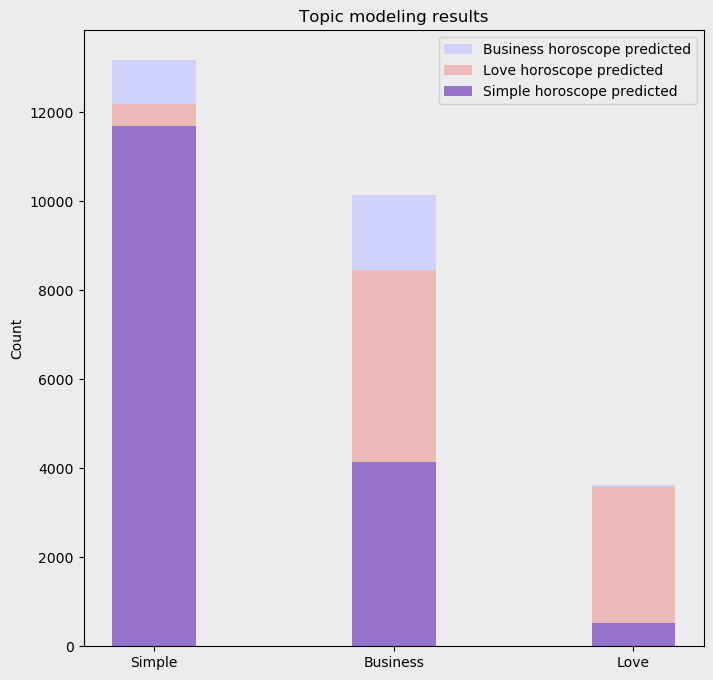

In [368]:
fig = plt.figure(figsize=(8, 8), facecolor='#ececec')
N = 3
business = table['business']
love = table['love']
simple = table['simple']
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ax = plt.gca()
ax.set_facecolor('#ececec')
p2 = plt.bar(ind, simple, width, color='#9774CC')
p1 = plt.bar(ind, love, width, bottom=simple, color='#EBBAB9')
p0 = plt.bar(ind, business, width, bottom=love+simple, color='#D1D2F9')

plt.ylabel('Count')
plt.title('Topic modeling results')
plt.xticks(ind, ('Simple', 'Business', 'Love'))
plt.legend((p0[0], p1[0], p2[0]), ('Business horoscope predicted', 'Love horoscope predicted', 'Simple horoscope predicted'),
           facecolor='#ececec')

plt.savefig('Plots/type_bar.png', facecolor=fig.get_facecolor(), dpi=300, edgecolor='none')
plt.show()